In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)



## Keşifçi Veri Analizi

In [2]:
df = pd.read_csv("datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
###############################
# Target'ın Analizi
###############################

In [4]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

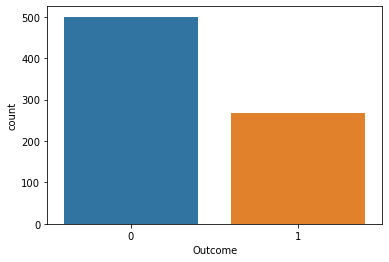

In [5]:
sns.countplot(x = "Outcome", data = df)
plt.show()

In [6]:
100 * df["Outcome"].value_counts() / len(df)

0   65.104
1   34.896
Name: Outcome, dtype: float64

In [7]:
################################
# Feature( bagımsız değişken analizi)
################################

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


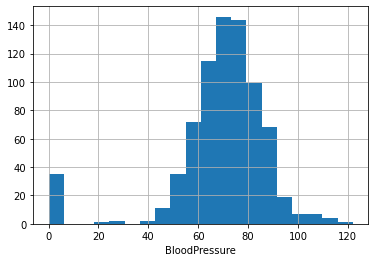

In [9]:
df["BloodPressure"].hist(bins = 20)
plt.xlabel("BloodPressure")
plt.show()

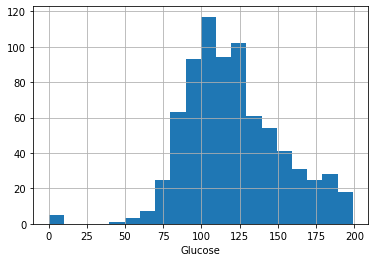

In [10]:
df["Glucose"].hist(bins = 20)
plt.xlabel("Glucose")
plt.show()

In [13]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins = 20)
    plt.xlabel(numerical_col)
    plt.show(block = True)

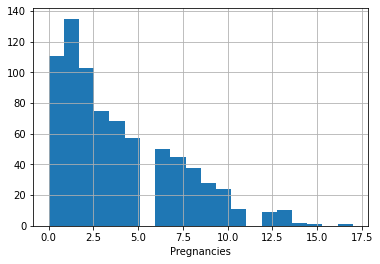

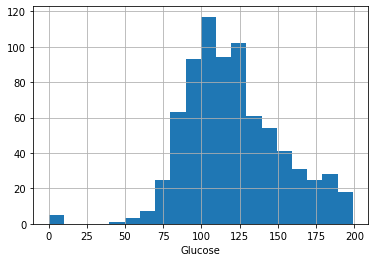

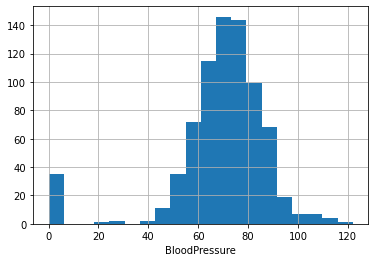

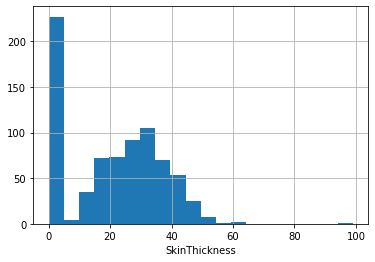

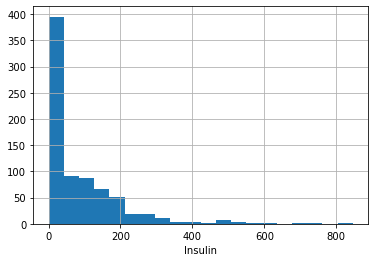

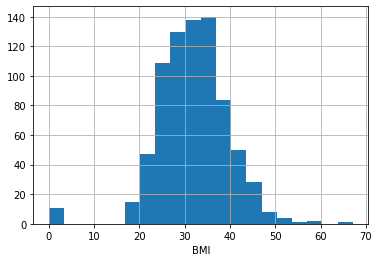

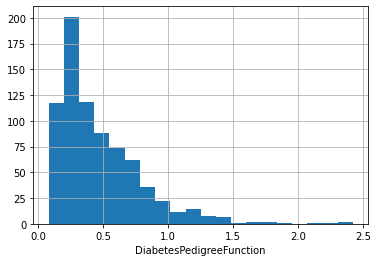

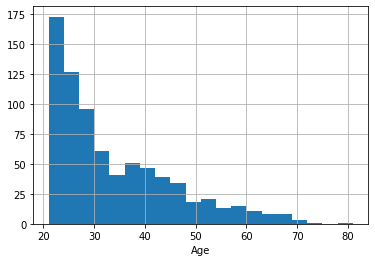

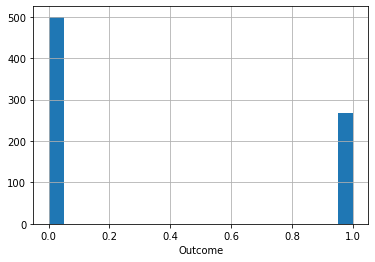

In [14]:
for col in df.columns:
    plot_numerical_col(df,col)

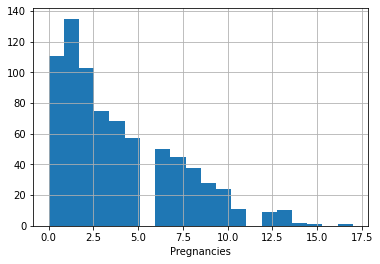

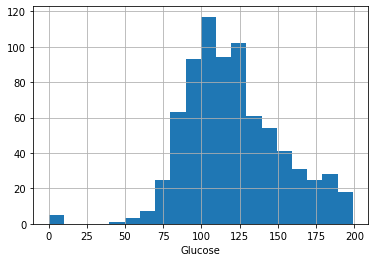

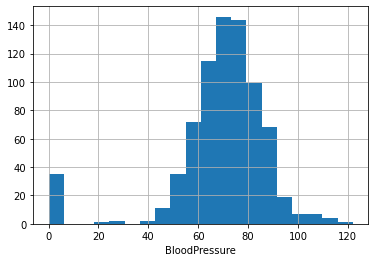

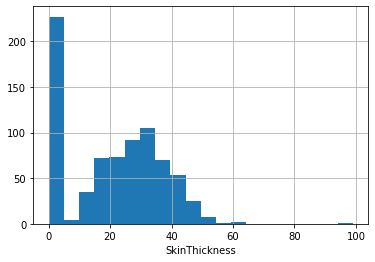

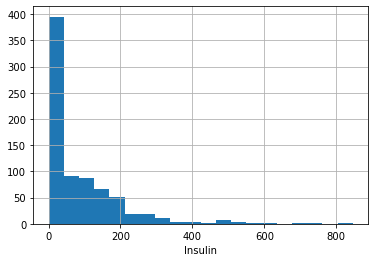

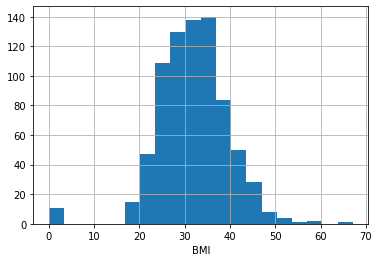

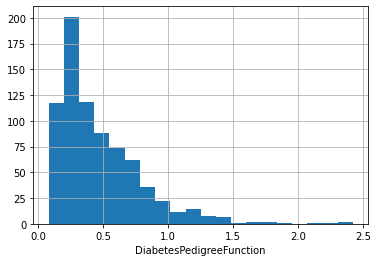

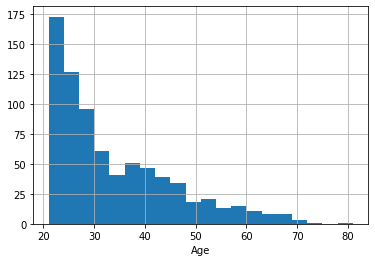

In [16]:
#outcome değişkenini dışarıda bırakmak istersek
cols = [col for col in df.columns if "Outcome" not in col]
for col in cols:
    plot_numerical_col(df,col)

In [17]:
############################
#Target vs Featıres
############################

In [18]:
df.groupby("Outcome").agg({"Pregnancies":"mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [20]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col:"mean"}),
          end = "\n\n\n")

In [21]:
for col in cols:
    target_summary_with_num(df,"Outcome",col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




## Veri Ön işleme

In [26]:
#Eksik değer var mı?
df.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [28]:
# Aykırı değer var mı?
for col in cols:
    print(col,check_outlier(df,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [30]:
replace_with_thresholds(df,"Insulin")
for col in cols:
    print(col,check_outlier(df,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [32]:
# Değişkenleri scale etmek: modellerin değişkenlere eşit yaklaşmasını sağlar. kullanılan parametre tahmin yontemlerinin daha hızlı ve doğru olmasını sağlar
#robustsclaer aykırı değerlerden etkilenmez. çünkü medyanı çıkarır ort u değil

In [34]:
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])
df.head()    

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,0.169,0.674,-0.600,-0.400,0.000,0.600,2.800
Glucose,768.000,0.094,0.775,-2.836,-0.436,0.000,0.564,1.988
BloodPressure,768.000,-0.161,1.075,-4.000,-0.556,0.000,0.444,2.778
SkinThickness,768.000,-0.077,0.499,-0.719,-0.719,0.000,0.281,2.375
Insulin,768.000,0.386,0.898,-0.240,-0.240,0.000,0.760,5.517
BMI,768.000,-0.001,0.848,-3.441,-0.505,0.000,0.495,3.774
DiabetesPedigreeFunction,768.000,0.260,0.866,-0.770,-0.337,0.000,0.663,5.353
Age,768.000,0.249,0.692,-0.471,-0.294,0.000,0.706,3.059
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


## Modelleme

In [40]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis = 1)
log_model = LogisticRegression().fit(X,y)


In [42]:
#sabit b-bias
log_model.intercept_ 

array([-1.23439588])

In [43]:
#katsayılar
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [44]:
y_pred = log_model.predict(X)

In [45]:
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [46]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

## Model Başarı Değerlendirme

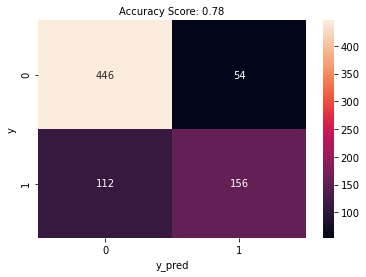

In [47]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

In [48]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



precision: 1 olarak yaptıgımız tahminlerin 0.74ü doğru tahmin
recall: 1 olanları 0.58 başarıyla doğru sınıflandırma
yorumları 1 sınıfına göre yaptık...

In [49]:
#########
# ROC AUC
#########

In [50]:
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8393955223880598

## Model Doğrulama : HOLDOUT :ikiye bölme

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.20,
                                                    random_state = 17)

In [56]:
log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)

y_prob = log_model.predict_proba(X_test)[:,1]

In [61]:
# Accuracy: 0.78 
# Precision: 0.74 çıktı
# Recall: 0.58 düştü
# F1-score: 0.65 
# ROC AUC: 0.83939

In [63]:
print(classification_report(y_test, y_pred))
# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



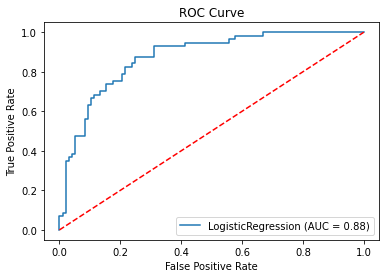

In [64]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()


In [65]:
# AUC
roc_auc_score(y_test, y_prob)

0.8755652016639537

In [66]:
######################################################
# Model Validation: 10-Fold Cross Validation
######################################################

In [69]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy",
                                     "precision", 
                                     "recall",
                                     "f1", 
                                     "roc_auc"])

# Accuracy: 0.78
# Precision: 0.74
# Recall: 0.58
# F1-score: 0.65

# Accuracy: 0.77
# Precision: 0.79
# Recall: 0.53
# F1-score: 0.63

In [71]:
cv_results['test_accuracy']
# Accuracy: 0.7721

array([0.77272727, 0.74675325, 0.75324675, 0.81699346, 0.77124183])

In [72]:
cv_results['test_accuracy'].mean()

0.7721925133689839

In [73]:
cv_results['test_precision'].mean()

0.7192472060223519

In [74]:
cv_results['test_recall'].mean()

0.5747030048916841

In [75]:
cv_results['test_f1'].mean()

0.6371421090986309

In [76]:
cv_results['test_roc_auc'].mean()

0.8327295597484277

In [77]:
######################################################
# Prediction for A New Observation
######################################################

X.columns

random_user = X.sample(1, random_state=45)
log_model.predict(random_user)

array([1], dtype=int64)